# FA24 - Assignment 3 - Convolutional Neural Networks

### Instructions
- Download the `Cannes_Fashion_dataset.csv` and `colours.zip`dataset from Moodle.
- Do **NOT** forget to type in your name and AUBNET After this cell.
- Do **NOT** upload the dataset with your submission.
- **If an assignment contains a copied solution, the entire assignment will be awarded 0 points for all individuals submitting the same solution. Furthermore, any solutions generated by AI tools, will also receive 0 points.**
- Name the assignment as follows: **Ast3_AUBNET.ipynb** . Failure to follow this naming convention will result in the notebook **not being graded**.
- For this assignment, you are required to utilize only the specified imported libraries for each section. Please refrain from changing or substituting the libraries provided. Failure to comply with this requirement may result in the assignment not being graded or may lead to delays until the end of the semester.

**CMPS 364 - Advanced Machine Learning**

Assignment 3 - Convolutional Neural Networks (CNN)

**By:** Ralph Mouawad - rmm85 - ID 202204667

**To:** Dr. Shady Elbassuoni

### WARNING

In [ ]:
pip install scikeras[tensorflow]

#PART1: Fashion Image Classification

## Import Libraries

In [ ]:
#### Some Libraries to help you out ####
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

#### Ensure that you use  a **seed = 42** or **random_state=42** for all operations that requires you to use randomness in your assignment.

## 1. Data Preprocess and Exploration

Preprocess the dataset.<br>
Visualize the features and data.<br>
What insights can be derived from this dataset, and how can we statistically enhance it?<br>

In [ ]:
df = pd.read_csv('Cannes_Fashion_dataset.csv')

df = df.drop_duplicates()
df = df.dropna()

df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,Ankle boot,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Handbag,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Shirt,0,0,0,0,0,0,0,0,1,...,15,0,0,11,114,50,28,0,0,0
3,Sweater,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,16,66,31,0,0
4,Sandal,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df['label'].value_counts()

,count
label,
Sandal,7000
Ankle boot,6998
Sneaker,6996
Pants,6994
Dress,6993
Handbag,5600
Sweater,4894
Coat,4198
Top,3500


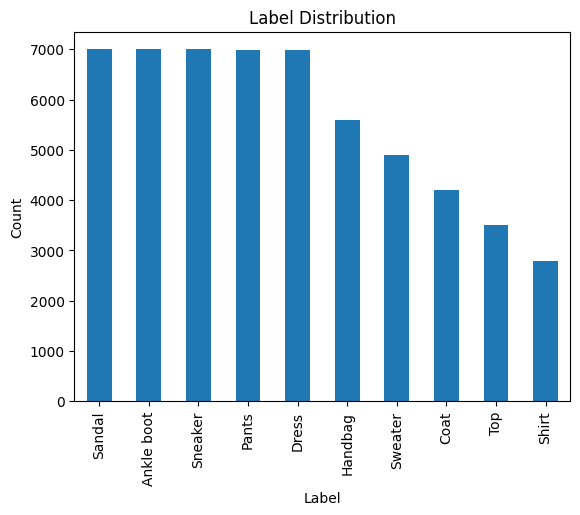

In [ ]:
df['label'].value_counts().plot(kind = 'bar')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

We can see that Handbag, Sweater, Coat, Top and Shirt have less instances than the other classes (around 3000 vs. 7000). This can cause the model to overfit the classes that have the most instances and not recognize the minorities.
We will use Stratified Sampling that will make sure that every set (train, val, test) has the same distribution of classes.
We will also use Image Data Generator to create synthetic samples of the underrepresented classes to make sure our model doesn't suffer from bias. We will make sure that all classes are represented equally.

## Split Data

Split your data into 80% training, 10% validation, 10 % testing

In [ ]:
X = df.drop('label', axis = 1)
X = X/255 # Normalize the data

Y = df[['label']]

In [ ]:
X_train_1, X_test, Y_train_1, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 42, stratify = Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_1, Y_train_1, test_size = 0.1/0.9, random_state = 42, stratify = Y_train_1)

In [ ]:
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
Y_val = encoder.transform(Y_val)
Y_test = encoder.transform(Y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
Y_test = to_categorical(Y_test)

Image Data Generator for handling imbalanced data. This is the same code used in assignment 2.

In [ ]:
X_train_reshaped = X_train.values.reshape(-1, 28, 28, 1)
target_count = 5600 # I want all classes to have max instances

class_labels = np.argmax(Y_train, axis = 1) # Since it is one hot encoded
class_counts = np.bincount(class_labels) # return the number of instances of each class
print('Before Data Augmentation')
for labels, count in zip(encoder.inverse_transform(np.unique(class_labels)), class_counts):
  print(f"{labels}: {count}")


# Image Data Generator
datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

augmented_X_train = []
augmented_Y_train = []

for label, count in enumerate(class_counts):

  if count < target_count:
    num_samples_to_generate = target_count - count

    class_indices = np.where(class_labels == label)[0] # retrieve indices of the label
    class_images = X_train_reshaped[class_indices]

    # Generation of synthetic data
    generated_images = 0
    for x_batch in datagen.flow(class_images, batch_size = 1):
      augmented_X_train.append(x_batch[0].reshape(28, 28, 1))
      augmented_Y_train.append(label)
      generated_images += 1
      if generated_images >= num_samples_to_generate:
        break

augmented_X_train = np.array(augmented_X_train)
augmented_Y_train = np.array(augmented_Y_train)

X_train_combined = np.concatenate((X_train_reshaped, augmented_X_train), axis = 0)
Y_train_combined = np.concatenate((Y_train, to_categorical(augmented_Y_train)), axis = 0)

# Shuffle the combined data
indices = np.random.permutation(len(X_train_combined))
X_train_combined = X_train_combined[indices]
Y_train_combined = Y_train_combined[indices]

# Restore to original shape
X_train = X_train_combined.reshape(X_train_combined.shape[0], -1)
Y_train = Y_train_combined

print('After Data Augmentation')
new_class_labels = np.argmax(Y_train, axis = 1) # Since it is one hot encoded
new_class_counts = np.bincount(new_class_labels) # return the number of instances of each class
for label, count in zip(encoder.inverse_transform(np.unique(new_class_labels)), new_class_counts):
    print(f"{label}: {count}")

Before Data Augmentation
Ankle boot: 5598
Coat: 3358
Dress: 5595
Handbag: 4480
Pants: 5595
Sandal: 5600
Shirt: 2238
Sneaker: 5596
Sweater: 3916
Top: 2800
After Data Augmentation
Ankle boot: 5600
Coat: 5600
Dress: 5600
Handbag: 5600
Pants: 5600
Sandal: 5600
Shirt: 5600
Sneaker: 5600
Sweater: 5600
Top: 5600


Plot generated data to see if it is realistic.

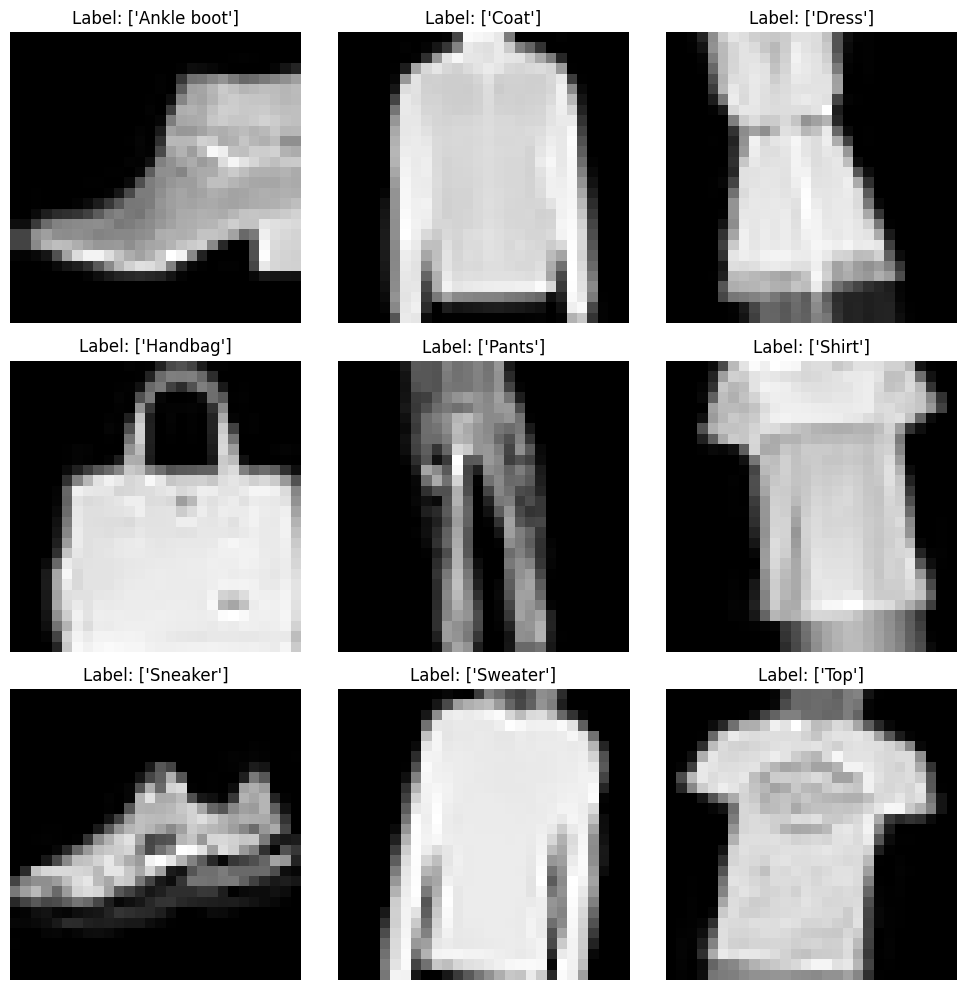

In [ ]:
unique_labels, unique_indices = np.unique(augmented_Y_train, return_index=True)

# Number of unique labels
num_unique_labels = len(unique_labels)

plt.figure(figsize=(10, 10))

for i, index in enumerate(unique_indices):
  plt.subplot(3, 3, i+1)
  plt.imshow(augmented_X_train[index].reshape(28, 28), cmap='gray')
  plt.title(f"Label: {encoder.inverse_transform(augmented_Y_train[[index]])}")
  plt.axis('off')
plt.tight_layout()
plt.show()

Change the shape of the data to tabular form so that we can apply convolutions using CNN.

In [ ]:
X_train = X_train.reshape(-1, 28, 28, 1) # Reshape as 28x28 matrix
X_val = X_val.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

## 2. Create Simple CNN Model

Create a simple CNN:

Use the create_simple_cnn() function to create a basic CNN model.
This model includes Conv2D layers,  MaxPooling2D layers, and Dense layers.

In [ ]:
def create_simple_cnn(input_shape, num_classes, num_conv_layers, filters_per_layer,
                      kernel_size, pool_size, dense_units, conv_dropout_rate, dense_dropout_rate,
                      learning_rate, decay_steps, decay_rate):

  model = Sequential()

  # Input Layer
  model.add(Input(shape = input_shape))

  # Convolutional Layers
  for i in range(num_conv_layers):
    # 2D Convolution
    model.add(Conv2D(filters = filters_per_layer[i], kernel_size = kernel_size[i], activation = 'relu'))
    # Max Pooling for the layer
    model.add(MaxPooling2D(pool_size = pool_size))
    # Add Dropout
    model.add(Dropout(conv_dropout_rate))

  # Flatten to 1D Vector
  model.add(Flatten())
  # Add Fully Connected Layer
  model.add(Dense(dense_units, activation = 'relu'))
  # Add Dropout for FC Layer
  model.add(Dropout(dense_dropout_rate))
  # Output Layer with Softmax Activation
  model.add(Dense(num_classes, activation = 'softmax'))

  # Adapt the Learning Rate
  lr_schedule = ExponentialDecay(
      initial_learning_rate = learning_rate,
      decay_steps = decay_steps,
      decay_rate = decay_rate
  )

  optimizer = Adam(learning_rate = lr_schedule)

  model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

  return model


In [ ]:
input_shape = (28, 28, 1)
num_classes = 10
num_conv_layers = 2
filters_per_layer = [32, 64]
kernel_size = [(3,3), (3,3)]
pool_size = (2, 2)
dense_units = 128
conv_dropout_rate = 0.2
dense_dropout_rate = 0.5
learning_rate = 0.001
decay_steps = 10000
decay_rate = 0.9

In [ ]:
model = create_simple_cnn(input_shape, num_classes, num_conv_layers, filters_per_layer,
                      kernel_size, pool_size, dense_units, conv_dropout_rate, dense_dropout_rate,
                      learning_rate, decay_steps, decay_rate)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [ ]:
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = 75, batch_size = 64, callbacks = [early_stopping])

Epoch 1/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 63s 70ms/step - accuracy: 0.6311 - loss: 0.9998 - val_accuracy: 0.8678 - val_loss: 0.3617
Epoch 2/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 83s 71ms/step - accuracy: 0.7942 - loss: 0.5443 - val_accuracy: 0.8839 - val_loss: 0.3119
Epoch 3/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 82s 71ms/step - accuracy: 0.8214 - loss: 0.4787 - val_accuracy: 0.9057 - val_loss: 0.2667
Epoch 4/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 79s 67ms/step - accuracy: 0.8334 - loss: 0.4402 - val_accuracy: 0.9114 - val_loss: 0.2519
Epoch 5/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - accuracy: 0.8463 - loss: 0.4127 - val_accuracy: 0.9166 - val_loss: 0.2379
Epoch 6/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 81s 67ms/step - accuracy: 0.8514 - loss: 0.4020 - val_accuracy: 0.9187 - val_loss: 0.2242
Epoch 7/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 95s 81ms/step - accuracy: 0.8624 - loss: 0.3693 - val_accuracy: 0.9239 - val_loss: 0.2157
Epoch 8/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 78s 77ms/step - accuracy: 0.8666 - loss: 0.3548 - 

### Learning Curve

Plot both the Loss and Accuracy curve Graph for both traning and validation. What do you observe from the curve? Does your model suffer from high bias/variance? Explain.

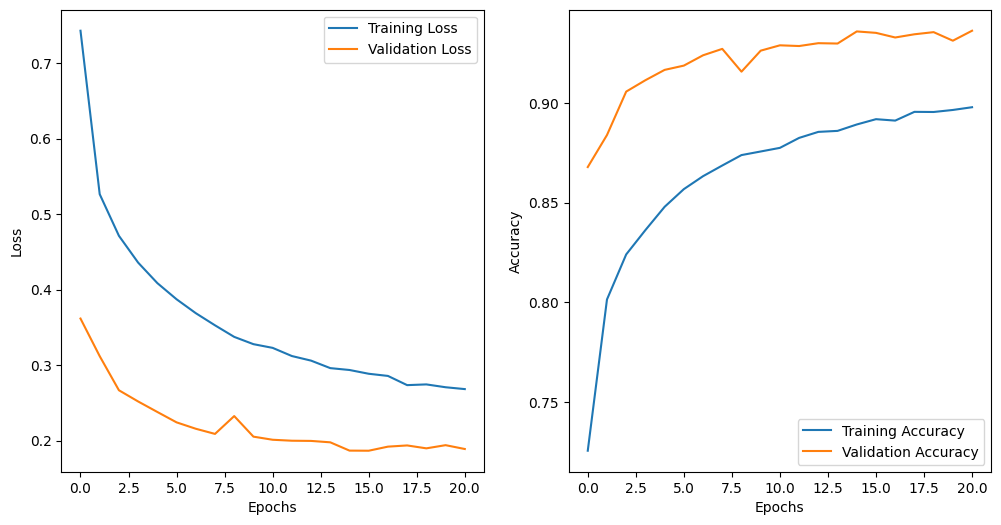

In [ ]:
plt.figure(figsize = (12,6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel  ('Accuracy')
plt.legend()

plt.show()

The learning curve suggests no overfitting and no underfitting as training and validation accuracy/loss are close to each other. Validation results are slightly better because we generated synthetic data for the training set as well as adding droupout which solved the issue of overfitting.

Both training and validation accuracy increased over epochs to reach good values. Similarly, training and validation loss decreased.

## 3. Create CNN with L2 regularization

Use the create_regularized_cnn() function to create a CNN with regularization.
This model applies L2 regularization to the kernel of each Conv2D and Dense layer.

In [ ]:
def create_regularized_cnn(input_shape, num_classes, filters_per_layer,
                      kernel_size, pool_size, dense_units, conv_dropout_rate, dense_dropout_rate,
                      learning_rate, decay_steps, decay_rate, l2_reg_strength_conv, l2_reg_strength_dense,
                      padding, strides):

  model = Sequential()

  # Input Layer
  model.add(Input(shape = input_shape))

  # Convolutional Layers
  for i in range(len(filters_per_layer)):
    # 2D Convolution
    model.add(Conv2D(filters = filters_per_layer[i], kernel_size = kernel_size, strides = strides, padding = padding, activation = 'relu', kernel_regularizer = l2(l2_reg_strength_conv)))
    # Max Pooling for the layer
    model.add(MaxPooling2D(pool_size = pool_size))
    # Add Dropout
    model.add(Dropout(conv_dropout_rate))

  # Flatten to 1D Vector
  model.add(Flatten())
  # Add Fully Connected Layer
  model.add(Dense(dense_units, activation = 'relu', kernel_regularizer = l2(l2_reg_strength_dense)))
  # Add Dropout for FC Layer
  model.add(Dropout(dense_dropout_rate))
  # Output Layer with Softmax Activation
  model.add(Dense(num_classes, activation = 'softmax'))

  # Adapt the Learning Rate
  lr_schedule = ExponentialDecay(
      initial_learning_rate = learning_rate,
      decay_steps = decay_steps,
      decay_rate = decay_rate
  )

  optimizer = Adam(learning_rate = lr_schedule)

  model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

  return model


In [ ]:
input_shape = (28, 28, 1)
num_classes = 10
filters_per_layer = [32, 64]
kernel_size = (3,3)
pool_size = (2, 2)
dense_units = 128
conv_dropout_rate = 0.2
dense_dropout_rate = 0.5
learning_rate = 0.001
decay_steps = 10000
decay_rate = 0.9
l2_reg_strength_conv = 0.001
l2_reg_strength_dense = 0.001
padding = 'same'
strides = (1, 1)

In [ ]:
model = create_regularized_cnn(input_shape, num_classes, filters_per_layer, kernel_size, pool_size, dense_units, conv_dropout_rate, dense_dropout_rate, learning_rate, decay_steps, decay_rate, l2_reg_strength_conv, l2_reg_strength_dense, padding, strides)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [ ]:
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = 75, batch_size = 64, callbacks = [early_stopping])

Epoch 1/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6739 - loss: 1.0874 - val_accuracy: 0.8792 - val_loss: 0.4795
Epoch 2/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8059 - loss: 0.6548 - val_accuracy: 0.8926 - val_loss: 0.4264
Epoch 3/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8186 - loss: 0.6065 - val_accuracy: 0.9023 - val_loss: 0.4153
Epoch 4/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8293 - loss: 0.5853 - val_accuracy: 0.9075 - val_loss: 0.3936
Epoch 5/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8346 - loss: 0.5709 - val_accuracy: 0.9103 - val_loss: 0.3935
Epoch 6/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8427 - loss: 0.5503 - val_accuracy: 0.9117 - val_loss: 0.3769
Epoch 7/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8450 - loss: 0.5466 - val_accuracy: 0.9069 - val_loss: 0.3894
Epoch 8/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8485 - loss: 0.5362 - val_accuracy: 0

### Learning Curve

Plot both the Loss and Accuracy curve Graph for both traning and validation. What do you observe from the curve? Does your model suffer from high bias/variance? Explain.

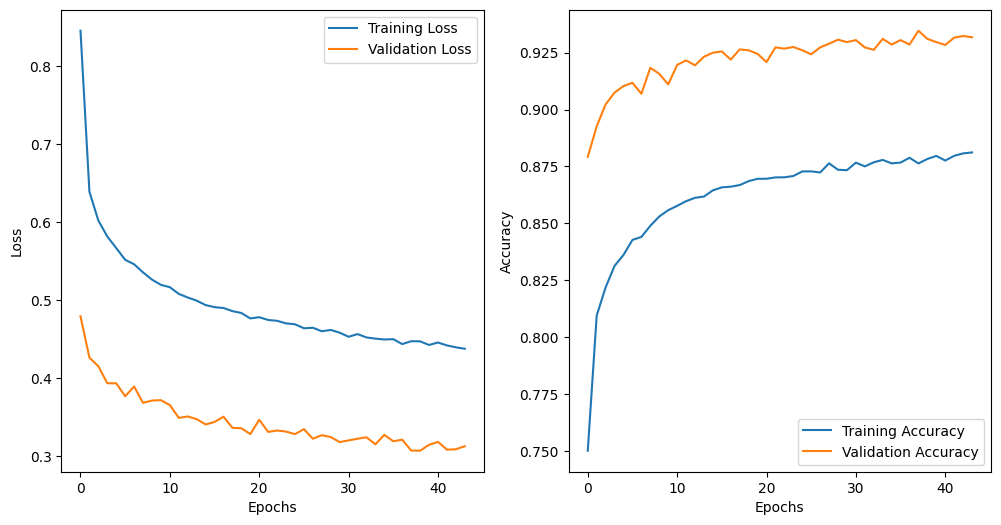

In [ ]:
plt.figure(figsize = (12,6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel  ('Accuracy')
plt.legend()
plt.show()

L2 regularization is used to overcome overfitting by shrinking the weights. Both our models don't suffer from overfitting as we used L2 regularization and dropout.

We have no high bias nor high variance suggesting that our model generalized the dataset that we had.

## 4. Hyperparameters Tuning

You will tune the hyperparameters of the above architecture `create_regularized_cnn()` using a random search approach. Utilize insights gained from the learning curve to guide your hyperparameter search process. Once the tuning is complete, report the optimal hyperparameter values, along with the validation accuracy and F-measure obtained from the validation set. At this stage, the purpose of using the validation set is to evaluate and fine-tune the hyperparameters iteratively.

Define the hyperparameter space: **NOTE: THESE ARE ONLY EXAMPLES**

1. Learning rate: log-uniform distribution (e.g., 1e-4 to 1e-2)
2. Dropout rate after each convolutional layer: uniform distribution (e.g., 0.0 to 0.5)
3. Dropout rate after the dense layer: uniform distribution (e.g., 0.0 to 0.5)
4. Mini-batch size: discrete values (e.g., [32, 64, 128, 256])
5. Number of convolutional layers: discrete values (e.g., [2, 3, 4])
6. Number of filters in each convolutional layer: discrete values (e.g., [32, 64, 128, 256])
7. Kernel size for convolutional layers: discrete values (e.g., [(3,3), (5,5)])
8. Number of units in the dense layer: discrete values (e.g., [64, 128, 256, 512])
9. L2 regularization strength for convolutional layers: log-uniform distribution (e.g., 1e-6 to 1e-3)
10. L2 regularization strength for dense layer: log-uniform distribution (e.g., 1e-6 to 1e-3)

In [ ]:
model = KerasClassifier(build_fn = create_regularized_cnn, input_shape = (28, 28, 1), num_classes = 10, verbose = 1)

param_grid = {
    'model__learning_rate': [0.0001, 0.001, 0.01],
    'model__conv_dropout_rate': [0.2, 0.3, 0.4],
    'model__dense_dropout_rate': [0.2, 0.3, 0.4],
    'batch_size': [32, 64],
    'model__filters_per_layer': [[32, 64], [32, 64, 128], [64, 128, 256]], # This specifies number of conv layers and number of filers
    'model__kernel_size': [(3,3), (5,5)],
    'model__dense_units': [128, 256, 512],
    'model__l2_reg_strength_conv': [0.0001, 0.001, 0.01],
    'model__l2_reg_strength_dense': [0.0001, 0.001, 0.01],
    'model__decay_steps': [1000, 2000],
    'model__decay_rate': [0.9, 0.95, 0.99],
    'model__pool_size': [(2,2), (3,3)],
    'model__padding': ['same', 'valid'],
    'model__strides': [(1,1), (2,2)]
}

# Predefined Split for Validation Data (same as assignment 2)
X_combined = np.concatenate((X_train, X_val))
Y_combined = np.concatenate((Y_train, Y_val))

test_fold = np.concatenate((np.full(X_train.shape[0], -1), np.zeros(X_val.shape[0])), axis =0)
split = PredefinedSplit(test_fold)

random_search = RandomizedSearchCV(
    estimator = model,
    param_distributions = param_grid,
    n_iter = 7,
    cv = split,
    verbose = 2
)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [ ]:
random_search.fit(X_combined, Y_combined, epochs = 35, callbacks = [early_stopping])

Fitting 1 folds for each of 7 candidates, totalling 7 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.1000 - loss: 2.3649
Epoch 2/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.1013 - loss: 2.3039
Epoch 3/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.1000 - loss: 2.3036
Epoch 4/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0998 - loss: 2.3034
Epoch 5/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.1003 - loss: 2.3030
Epoch 6/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0995 - loss: 2.3030
Epoch 7/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0998 - loss: 2.3031
Epoch 8/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.1001 - loss: 2.3030
Epoch 9/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0975 - loss: 2.3030
Epoch 10/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0986 - loss: 2.3029
Epoch 11/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.0964 - loss: 2.3029
Epoch 12/35
1750/1750 ━━━━

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5824 - loss: 1.6127
Epoch 2/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.6866 - loss: 1.0456
Epoch 3/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6963 - loss: 1.0134
Epoch 4/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6995 - loss: 0.9952
Epoch 5/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7026 - loss: 0.9775
Epoch 6/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7027 - loss: 0.9764
Epoch 7/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7035 - loss: 0.9708
Epoch 8/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7080 - loss: 0.9600
Epoch 9/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7100 - loss: 0.9458
Epoch 10/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7068 - loss: 0.9541
Epoch 11/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7149 - loss: 0.9375
Epoch 12/35
1750/1750

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6357 - loss: 1.0079
Epoch 2/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8036 - loss: 0.5474
Epoch 3/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8231 - loss: 0.4993
Epoch 4/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8344 - loss: 0.4681
Epoch 5/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8446 - loss: 0.4445
Epoch 6/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8511 - loss: 0.4262
Epoch 7/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8567 - loss: 0.4147
Epoch 8/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8579 - loss: 0.4146
Epoch 9/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8600 - loss: 0.4068
Epoch 10/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8650 - loss: 0.3965
Epoch 11/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8693 - loss: 0.3886
Epoch 12/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/35
[CV] END batch_size=64, model__conv_dropout_rate=0.3, model__decay_rate=0.95, model__decay_steps=1000, model__dense_dropout_rate=0.3, model__dense_units=512, model__filters_per_layer=[64, 128, 256], model__kernel_size=(3, 3), model__l2_reg_strength_conv=0.01, model__l2_reg_strength_dense=0.001, model__learning_rate=0.0001, model__padding=valid, model__pool_size=(3, 3), model__strides=(1, 1); total time=   1.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=32, model__conv_dropout_rate=0.2, model__decay_rate=0.95, model__decay_steps=1000, model__dense_dropout_rate=0.2, model__dense_units=256, model__filters_per_layer=[64, 128, 256], model__kernel_size=(5, 5), model__l2_reg_strength_conv=0.0001, model__l2_reg_strength_dense=0.0001, model__learning_rate=0.01, model__padding=valid, model__pool_size=(3, 3), model__strides=(1, 1); total time=   0.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6196 - loss: 1.2034
Epoch 2/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7840 - loss: 0.7033
Epoch 3/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8051 - loss: 0.6292
Epoch 4/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8186 - loss: 0.5944
Epoch 5/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8210 - loss: 0.5814
Epoch 6/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8288 - loss: 0.5591
Epoch 7/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8323 - loss: 0.5472
Epoch 8/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8353 - loss: 0.5316
Epoch 9/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8381 - loss: 0.5282
Epoch 10/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8426 - loss: 0.5191
Epoch 11/35
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8439 - loss: 0.5071
Epoch 12/35
1750/1750 ━━━━━━━━

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5438 - loss: 1.9369
Epoch 2/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7463 - loss: 1.1867
Epoch 3/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7774 - loss: 1.0209
Epoch 4/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7906 - loss: 0.9097
Epoch 5/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8063 - loss: 0.8177
Epoch 6/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8170 - loss: 0.7460
Epoch 7/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8263 - loss: 0.6880
Epoch 8/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8290 - loss: 0.6507
Epoch 9/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8360 - loss: 0.6143
Epoch 10/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8393 - loss: 0.5884
Epoch 11/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8454 - loss: 0.5585
Epoch 12/35
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 7.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrapp

Epoch 1/35
963/963 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6447 - loss: 0.9676
Epoch 2/35
963/963 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8058 - loss: 0.5416
Epoch 3/35
963/963 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8268 - loss: 0.4895
Epoch 4/35
963/963 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8422 - loss: 0.4536
Epoch 5/35
963/963 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8517 - loss: 0.4281
Epoch 6/35
963/963 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8557 - loss: 0.4207
Epoch 7/35
963/963 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8624 - loss: 0.4051
Epoch 8/35
963/963 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8631 - loss: 0.4018
Epoch 9/35
963/963 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8659 - loss: 0.3938
Epoch 10/35
963/963 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8664 - loss: 0.3920
Epoch 11/35
963/963 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8730 - loss: 0.3791
Epoch 12/35
963/963 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/ste

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=KerasClassifier(build_fn=<function create_regularized_cnn at 0x7bb3b28d77f0>, input_shape=(28, 28, 1), num_classes=10),
                   n_iter=7,
                   param_distributions={'batch_size': [32, 64],
                                        'model__conv_dropout_rate': [0.2, 0.3,
                                                                     0.4],
                                        'model__decay_rate': [0.9, 0.95, 0.99],
                                        'model__decay_steps': [1000, 2...
                                        'model__filters_per_layer': [[32, 64],
                                                                     [32, 64,
                                                                      128],
                                                                     [64, 128,
                                                                      256]],
                                        'model__kernel_size': [(3, 3), (5, 5)],
                                        'model__l2_reg_strength_conv': [0.0001,
                                                                        0.001,
                                                                        0.01],
                                        'model__l2_reg_strength_dense': [0.0001,
                                                                         0.001,
                                                                         0.01],
                                        'model__learning_rate': [0.0001, 0.001,
                                                                 0.01],
                                        'model__padding': ['same', 'valid'],
                                        'model__pool_size': [(2, 2), (3, 3)],
                                        'model__strides': [(1, 1), (2, 2)]},
                   verbose=2)

I will take the best set of hyperparameters from random search (from the report it gave me) and re-train it and evaluate it on the validation set.

Random Search took a lot of time to run and runtime disconnected before I save the best model. That's why I re-trained the best model again.

In [ ]:
# Best Hyperparameters from the report of RandomSearch (sorry but I forgot to print the best estimators after completing random search)
input_shape = (28, 28, 1)
num_classes = 10
filters_per_layer = [32, 64]
kernel_size = (5,5)
pool_size = (3, 3)
dense_units = 512
conv_dropout_rate = 0.2
dense_dropout_rate = 0.2
learning_rate = 0.001
decay_steps = 10000
decay_rate = 0.99
l2_reg_strength_conv = 0.0001
l2_reg_strength_dense = 0.0001
padding = 'valid'
strides = (1, 1)


In [ ]:
best_model = create_regularized_cnn(input_shape, num_classes, filters_per_layer, kernel_size, pool_size, dense_units, conv_dropout_rate, dense_dropout_rate, learning_rate, decay_steps, decay_rate, l2_reg_strength_conv, l2_reg_strength_dense, padding, strides)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

best_history = best_model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = 75, batch_size = 64, callbacks = [early_stopping])

Epoch 1/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.6196 - loss: 1.0204 - val_accuracy: 0.8476 - val_loss: 0.4552
Epoch 2/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.7930 - loss: 0.5677 - val_accuracy: 0.8864 - val_loss: 0.3759
Epoch 3/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - accuracy: 0.8196 - loss: 0.5028 - val_accuracy: 0.8890 - val_loss: 0.3440
Epoch 4/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - accuracy: 0.8328 - loss: 0.4723 - val_accuracy: 0.9021 - val_loss: 0.3149
Epoch 5/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.8438 - loss: 0.4457 - val_accuracy: 0.9075 - val_loss: 0.3053
Epoch 6/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.8468 - loss: 0.4379 - val_accuracy: 0.9046 - val_loss: 0.3094
Epoch 7/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.8569 - loss: 0.4182 - val_accuracy: 0.9151 - val_loss: 0.2835
Epoch 8/75
875/875 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - accuracy: 0.8591 - loss: 0.4086 - 

In [ ]:
final_val_accuracy = best_history.history['val_accuracy'][-1]

print("Final Validation Accuracy", final_val_accuracy)

Final Validation Accuracy 0.9221011400222778


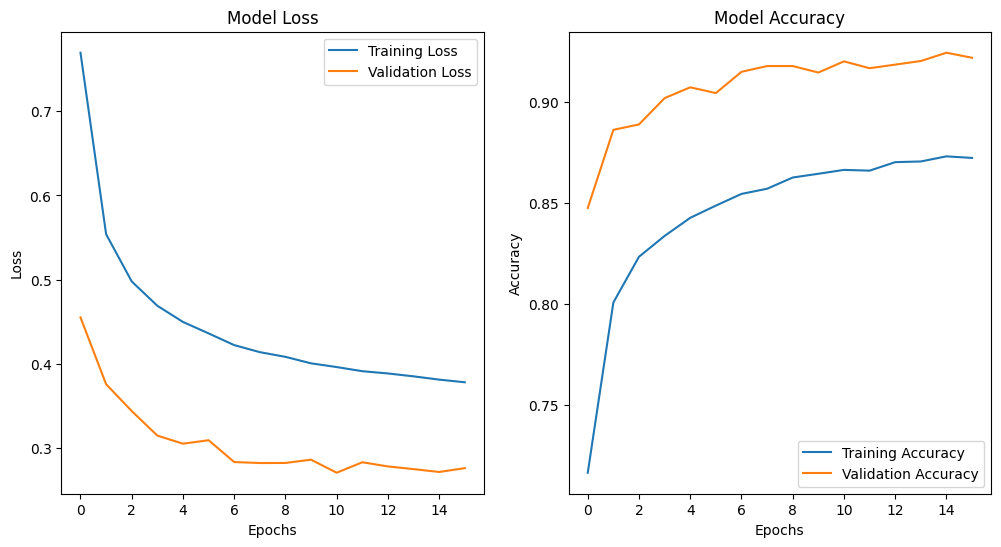

In [ ]:
# Plot the Learning Curve
plt.figure(figsize = (12,6))

plt.subplot(1, 2, 1)
plt.plot(best_history.history['loss'], label  = 'Training Loss')
plt.plot(best_history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_history.history['accuracy'], label = 'Training Accuracy')
plt.plot(best_history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

Same results as before

## 4. Model Evaluation on testing set

Evaluate and report results:

- Extract the best hyperparameters from the search results.
- Report the optimal hyperparameter values.
- Evaluate the best model on the testing set and report:

    - Testing accuracy
    - Testing F1-score

In [ ]:
test_loss, test_accuracy = best_model.evaluate(X_test, Y_test)

print("Testing Accuracy:", test_accuracy)

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9198 - loss: 0.2766
Testing Accuracy: 0.9197927713394165


In [ ]:
from sklearn.metrics import f1_score
y_pred_prob = best_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis = 1)

y_true = np.argmax(Y_test, axis = 1)

f1 = f1_score(y_true, y_pred, average = 'weighted')
print("F1 Score: ", f1)

175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
F1 Score:  0.9201434046252525


Test accuracy is very good and close to validation accuracy. We can conclude that our model generalizes well our dataset.

Plot the AUC-ROC Curve. Comment and analyze.

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_true_box = label_binarize(y_true, classes = range(len(np.unique(y_true))))
y_pred_box = label_binarize(y_pred, classes = range(len(np.unique(y_pred))))

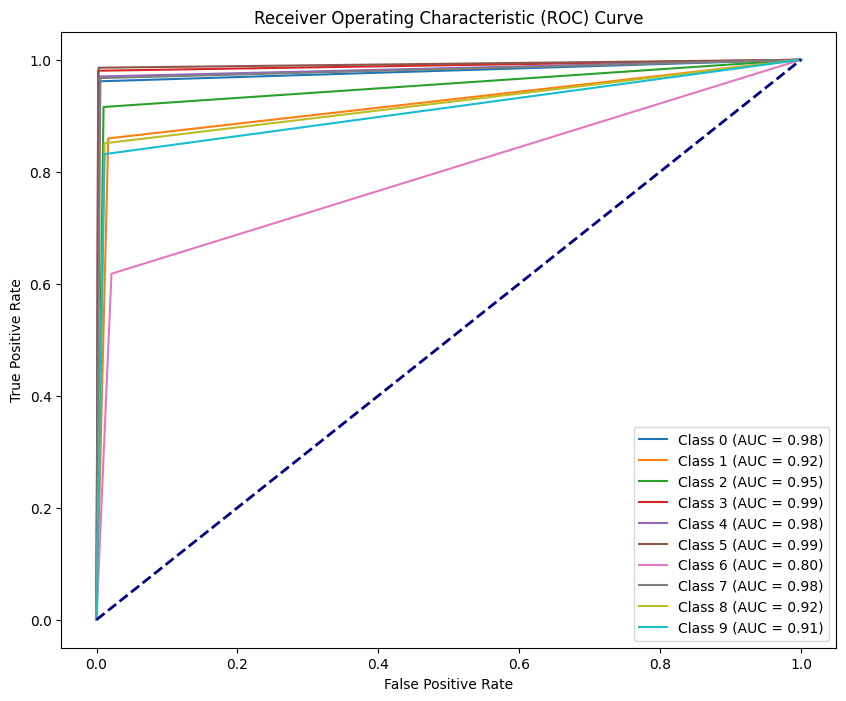

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_true))):
  fpr, tpr, _ = roc_curve(y_true_box[:, i], y_pred_box[:, i])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label = f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color = 'navy', lw=2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.show()

## Comparison and Analysis
Compare the simple CNN model with the one that uses L2 regularization. Analyze and comment. What type of layer can be used to prevent overfitting and is considered a regularization layer?

The curve shows that our model performed well to classify almost all categories with scores around 0.9-0.99.

However class 6 has a lower score of around 0.8 even though we generated a lot of samples in the training phase. But even with this, the model couldn't learn a lot of features and misclassified it with other classes that have shapes toverlapping with shirts.

Layers that can be used to prevent overfitting are Droupout (deactivating some neurons during training) and L2 regularization which have been used.

The simple CNN and the one with regularization performed similarly. However, it could have been possible that a simple model can suffer from overfitting which can be solved by adding the L2 regularization or droupout layers. In my case, the simple model had dropout layers which could have solved the issue of overfitting early on.

# PART2 : Breathing Life into Black & White

We will be using the cat category from CIFAR-10 dataset, which contains 32x32 pixel images for the problem that follows.
The following helper function will help you with downloading and unpacking the data

In [12]:
# Helper functions for loading data
# adapted from
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
import pickle
import sys
import tarfile

import numpy as np
from PIL import Image
from six.moves.urllib.request import urlretrieve


def get_file(fname, origin, untar=False, extract=False, archive_format="auto", cache_dir="data"):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + ".tar.gz"
    else:
        fpath = os.path.join(datadir, fname)

    print("File path: %s" % fpath)
    if not os.path.exists(fpath):
        print("Downloading data from", origin)

        error_msg = "URL fetch failure on {}: {} -- {}"
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print("Extracting file.")
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath


def load_batch(fpath, label_key="labels"):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, "rb")
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding="bytes")
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode("utf8")] = v
        d = d_decoded
    f.close()
    data = d["data"]
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = "cifar-10-batches-py"
    origin = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype="uint8")
    y_train = np.zeros((num_train_samples,), dtype="uint8")

    for i in range(1, 6):
        fpath = os.path.join(path, "data_batch_" + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000 : i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000 : i * 10000] = labels

    fpath = os.path.join(path, "test_batch")
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

## Coloring as Classification Problem
We will choose a set of 24 distinct colors and approach colorization as a pixel-level classification task, assigning each pixel one of the 24 color labels. These 24 colors are determined by applying [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) on the color data and selecting the cluster centroids. <br>

The cluster centers have already been generated for you and are provided. To keep things simple, we will calculate distance in RGB space. Although this is not the most optimal approach, it minimizes software dependencies for this assignment.

In [13]:
######################################################################
#ADDING OR MODIFYING LIBRARIES IN THIS SECTION IS STRICTLY PROHIBITED#
######################################################################
# Standard libraries
import argparse  # Argument parsing for command-line options
import time      # Time-related utilities for measuring performance
import math      # Mathematical functions

# Scientific computing libraries
import numpy as np         # Core numerical computing library
import numpy.random as npr # Random number generation utilities from NumPy
import scipy.misc          # Miscellaneous functions from SciPy (deprecated, consider alternatives)

# PyTorch libraries
import torch               # Core PyTorch functionality for tensors
import torch.nn as nn      # Neural network module definitions
import torch.nn.functional as F  # Functional interface for layers and activations
from torch.autograd import Variable  # Autograd support for automatic differentiation

# Visualization libraries
import matplotlib          # Main module for matplotlib
import matplotlib.pyplot as plt  # Plotting utilities from matplotlib


CAT_CATEGORY = 3

## Helper Code

In [14]:
def get_rgb_categ_cat(xs, colours):
    """
    Determine color categories from RGB values. This function manages
    the processing by dividing the task into smaller, memory-efficient
    chunks, and delegates the actual computation to the helper function
    _get_rgb_categ_cat.

    Args:
      xs: numpy array of RGB images with shape [B, C, H, W]
      colours: numpy array containing color categories and their corresponding RGB values

    Returns:
      result: numpy array of integers with shape [B, 1, H, W]
    """
    if np.shape(xs)[0] < 100:
        return _get_rgb_categ_cat(xs)
    batch_sz = 100
    nexts = []
    for i in range(0, np.shape(xs)[0], batch_sz):
        next = _get_rgb_categ_cat(xs[i : i + batch_sz, :, :, :], colours)
        nexts.append(next)
    result = np.concatenate(nexts, axis=0)
    return result


def _get_rgb_categ_cat(xs, colours):
    """
    Assign color categories based on RGB values by selecting the closest
    color (in RGB space) from the `colours` array for each pixel in the
    image `xs`. Note that this operation is memory-intensive, so ensure
    `xs` is not too large.

    Args:
      xs: numpy array of RGB images with shape [B, C, H, W]
      colours: numpy array containing color categories and their RGB values

    Returns:
      result: numpy array of integers with shape [B, 1, H, W]
    """
    num_col = np.shape(colours)[0]
    xs = np.expand_dims(xs, 0)
    cs = np.reshape(colours, [num_col, 1, 3, 1, 1])
    dists = np.linalg.norm(xs - cs, axis=2)  # 2 = colour axis
    cat = np.argmin(dists, axis=0)
    cat = np.expand_dims(cat, axis=1)
    return cat


def get_categ_rgb_cat(cats, colours):
    """
    Retrieve RGB values based on given color categories.

    Args:
      cats: integer numpy array representing color categories
      colours: numpy array containing color categories and their corresponding RGB values

    Returns:
      numpy array of RGB values
    """
    return colours[cats]


def process_data(xs, ys, max_pixel=256, down_sz_input=False):
    """
    Pre-process CIFAR10 images by selecting only the CAT category,
    shuffling the data, and normalizing the color values to be between 0 and 1.

    Args:
      xs: array of RGB pixel values
      ys: array of category labels
      max_pixel: maximum pixel value in the original dataset

    Returns:
      xs: shuffled and normalized RGB images
      grey: greyscale images, also normalized to have values between 0 and 1
    """
    xs = xs / max_pixel
    xs = xs[np.where(ys == CAT_CATEGORY)[0], :, :, :]
    npr.shuffle(xs)

    grey = np.mean(xs, axis=1, keepdims=True)

    if down_sz_input:
        downsize_mod = nn.Sequential(
            nn.AvgPool2d(2),
            nn.AvgPool2d(2),
            nn.Upsample(scale_factor=2),
            nn.Upsample(scale_factor=2),
        )
        xs_downsized = downsize_mod.forward(torch.from_numpy(xs).float())
        xs_downsized = xs_downsized.data.numpy()
        return (xs, xs_downsized)
    else:
        return (xs, grey)


def get_batch(x, y, batch_sz):
    """
    Generator that yields data in batches.

    Args:
      x: input data
      y: output data
      batch_sz: size of each batch

    Yields:
      batch_x: a batch of input data, with size up to batch_sz
      batch_y: a batch of output data, with size up to batch_sz
    """
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_sz):
        batch_x = x[i : i + batch_sz, :, :, :]
        batch_y = y[i : i + batch_sz, :, :, :]
        yield (batch_x, batch_y)

In [15]:
def get_torch_vars_xs_ys(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to PyTorch tensors.
    If a GPU is available, the tensors are moved to the GPU.

    Args:
      xs (numpy array): greyscale input data
      ys (numpy array): categorical labels
      gpu (bool): flag indicating whether to move tensors to GPU

    Returns:
      xs (torch.Tensor), ys (torch.Tensor): converted PyTorch tensors
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).long()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)


def compute_loss(criterion, outputs, labels, batch_sz, num_col):
    """
    Helper function to compute the loss for a pixel-wise prediction task.
    The output and ground truth tensors are reshaped into 2D tensors
    before being passed to the loss criterion.

    Args:
      criterion: PyTorch loss function
      outputs (torch.Tensor): predicted labels from the model
      labels (torch.Tensor): ground truth labels
      batch_sz (int): batch size used during training
      num_col (int): number of color categories

    Returns:
      torch.Tensor: computed loss
    """
    batch = outputs.size(0)
    loss_out = outputs.transpose(1, 3).contiguous().view([batch * 32 * 32, num_col])
    loss_lab = labels.transpose(1, 3).contiguous().view([batch * 32 * 32])
    return criterion(loss_out, loss_lab)


def run_validation(
    cnn,
    criterion,
    test_img_grey,
    test_categ_rgb_cat,
    batch_sz,
    colours,
    path_plt=None,
    is_plot=True,
    down_sz_input=False
):
    correct = 0.0
    total = 0.0
    losses = []
    num_col = np.shape(colours)[0]
    for i, (xs, ys) in enumerate(get_batch(test_img_grey, test_categ_rgb_cat, batch_sz)):
        images, labels = get_torch_vars_xs_ys(xs, ys, args.gpu)
        outputs = cnn(images)

        val_loss = compute_loss(
            criterion, outputs, labels, batch_sz=args.batch_sz, num_col=num_col
        )
        losses.append(val_loss.data.item())

        _, predicted = torch.max(outputs.data, 1, keepdim=True)
        total += labels.size(0) * 32 * 32
        correct += (predicted == labels.data).sum()

    if path_plt:
        plot_img(
            xs,
            ys,
            predicted.cpu().numpy(),
            colours,
            path_plt,
            is_plot=is_plot,
            compare_bilinear=down_sz_input,
        )

    val_loss = np.mean(losses)
    val_acc = 100 * correct / total
    return val_loss, val_acc

In [16]:
def plot_img(xs, gtlabel, output, colours, path, is_plot, compare_bilinear=False):
    """
    Generate PNG plots of the xs, ground truth, and model outputs.

    Args:
      xs: greyscale input to the colorization CNN
      gtlabel: ground truth color categories for each pixel
      output: predicted color categories for each pixel
      colours: numpy array containing color categories and their corresponding RGB values
      path: output path for saving the plots
      is_plot: whether to display the figures inline or save them to the specified path
    """
    grey = np.transpose(xs[:10, :, :, :], [0, 2, 3, 1])
    gtcolor = get_categ_rgb_cat(gtlabel[:10, 0, :, :], colours)
    predcolor = get_categ_rgb_cat(output[:10, 0, :, :], colours)

    img_stack = [np.hstack(np.tile(grey, [1, 1, 1, 3])), np.hstack(gtcolor), np.hstack(predcolor)]

    if compare_bilinear:
        downsize_module = nn.Sequential(
            nn.AvgPool2d(2),
            nn.AvgPool2d(2),
            nn.Upsample(scale_factor=2, mode="bilinear"),
            nn.Upsample(scale_factor=2, mode="bilinear"),
        )
        gt_input = np.transpose(
            gtcolor,
            [
                0,
                3,
                1,
                2
            ],
        )
        color_bilin = downsize_module.forward(torch.from_numpy(gt_input).float())
        color_bilin = np.transpose(color_bilin.data.numpy(), [0, 2, 3, 1])
        img_stack = [
            np.hstack(np.transpose(xs[:10, :, :, :], [0, 2, 3, 1])),
            np.hstack(gtcolor),
            np.hstack(predcolor),
            np.hstack(color_bilin),
        ]
    img = np.vstack(img_stack)

    plt.grid(None)
    plt.imshow(img, vmin=0.0, vmax=1.0)
    if is_plot:
        plt.show()
    else:
        plt.savefig(path)


def toimage(img, cmin, cmax):
    return Image.fromarray((img.clip(cmin, cmax) * 255).astype(np.uint8))


def plot_acts(args, cnn):
    # Load color categories from file
    colours = np.load(args.colours, allow_pickle=True)[0]
    num_col = np.shape(colours)[0]

    # Load and preprocess CIFAR-10 dataset
    (x_train, y_train), (x_test, y_test) = load_cifar10()
    test_rgb, test_img_grey = process_data(x_test, y_test, down_sz_input=args.down_sz_input)
    test_categ_rgb_cat = get_rgb_categ_cat(test_rgb, colours)

    # Select a specific test image by index
    id = args.index
    outdir = f"outputs/{args.experiment_name}/act{id}"
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    # Prepare input image and label for the model
    images, labels = get_torch_vars_xs_ys(
        np.expand_dims(test_img_grey[id], 0), np.expand_dims(test_categ_rgb_cat[id], 0)
    )

    # Move model to CPU and generate output
    cnn.cpu()
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1, keepdim=True)

    # Convert predicted output to RGB color
    predcolor = get_categ_rgb_cat(predicted.cpu().numpy()[0, 0, :, :], colours)
    img = predcolor

    # Save the predicted color image
    toimage(predcolor, cmin=0, cmax=1).save(os.path.join(outdir, f"output_{id}.png"))

    # Prepare and save the input image
    if not args.down_sz_input:
        img = np.tile(np.transpose(test_img_grey[id], [1, 2, 0]), [1, 1, 3])
    else:
        img = np.transpose(test_img_grey[id], [1, 2, 0])
    toimage(img, cmin=0, cmax=1).save(os.path.join(outdir, f"input_{id}.png"))

    # Save the ground truth RGB image
    img = np.transpose(test_rgb[id], [1, 2, 0])
    toimage(img, cmin=0, cmax=1).save(os.path.join(outdir, f"input_{id}_gt.png"))

    def add_border(img):
        """Add a white border around the image."""
        return np.pad(img, 1, "constant", constant_values=1.0)

    def draw_acts(path, activation, imgwidth=4):
        """
        Draw activation maps and save them as an image.

        Args:
            path (str): Path to save the output image
            activation (numpy.array): Activation maps
            imgwidth (int): Number of activation maps per row
        """
        img = np.vstack(
            [
                np.hstack(
                    [
                        add_border(filter)
                        for filter in activation[i * imgwidth : (i + 1) * imgwidth, :, :]
                    ]
                )
                for i in range(activation.shape[0] // imgwidth)
            ]
        )
        scipy.misc.imsave(path, img)

    # Save activation maps for each convolutional layer
    for i, tensor in enumerate([cnn.out1, cnn.out2, cnn.out3, cnn.out4, cnn.out5]):
        draw_acts(
            os.path.join(outdir, f"conv{i+1}_out_{id}.png"), tensor.data.cpu().numpy()[0]
        )

    print(f"Visualization results are saved to {outdir}")

In [17]:
class AttrDictionary(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDictionary, self).__init__(*args, **kwargs)
        self.__dict__ = self

def train(args, cnn=None):
    # Set the maximum number of threads for PyTorch
    torch.set_num_threads(5)
    # Set the random seed for NumPy to ensure reproducibility
    npr.seed(args.seed)

    # Define the directory for saving outputs
    save_dir = "outputs/" + args.experiment_name

    # Load color categories from file
    colours = np.load(args.colours, allow_pickle=True, encoding="bytes")[0]
    num_col = np.shape(colours)[0]

    # Determine the number of input channels based on down_sz_input flag
    num_in_channels = 1 if not args.down_sz_input else 3

    # Initialize the CNN model if not provided
    if cnn is None:
        Net = globals()[args.model]
        cnn = Net(args.kernel, args.num_filters, num_col, num_in_channels)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)

    # Load and preprocess CIFAR-10 dataset
    print("Loading CIFAR-10 data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming CIFAR-10 data...")
    train_rgb, train_grey = process_data(x_train, y_train, down_sz_input=args.down_sz_input)
    train_rgb_cat = get_rgb_categ_cat(train_rgb, colours)
    test_rgb, test_img_grey = process_data(x_test, y_test, down_sz_input=args.down_sz_input)
    test_categ_rgb_cat = get_rgb_categ_cat(test_rgb, colours)

    # Create output directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training CNN Model ...")
    if args.gpu:
        cnn.cuda()  # Move model to GPU if available
    start = time.time()

    # Initialize lists to store training and validation metrics
    train_losses, valid_losses, valid_accs = [], [], []

    # Main training loop
    for epoch in range(args.epochs):
        # Train the model
        cnn.train()  # Set model to training mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb_cat, args.batch_sz)):
            images, labels = get_torch_vars_xs_ys(xs, ys, args.gpu)

            # Forward pass, backward pass, and optimization
            optimizer.zero_grad()
            outputs = cnn(images)
            loss = compute_loss(criterion, outputs, labels, batch_sz=args.batch_sz, num_col=num_col)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        # Plot training images if specified
        if args.plot:
            _, predicted = torch.max(outputs.data, 1, keepdim=True)
            plot_img(xs, ys, predicted.cpu().numpy(), colours,
                     save_dir + "/train_%d.png" % epoch, args.is_plot, args.down_sz_input)

        # Calculate and log average loss for the epoch
        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        time_elapsed = time.time() - start
        print(f"Epoch [{epoch + 1}/{args.epochs}], Loss: {avg_loss:.4f}, Time (s): {time_elapsed:.2f}")

        # Evaluate the model on validation set
        cnn.eval()  # Set model to evaluation mode
        val_loss, val_acc = run_validation(cnn, criterion, test_img_grey, test_categ_rgb_cat,
                                                args.batch_sz, colours,
                                                save_dir + "/test_%d.png" % epoch,
                                                args.is_plot, args.down_sz_input)

        # Log validation results
        time_elapsed = time.time() - start
        valid_losses.append(val_loss)
        valid_accs.append(val_acc)
        print(f"Epoch [{epoch + 1}/{args.epochs}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.1f}%, Time(s): {time_elapsed:.2f}")

    # Plot training curve
    plt.figure()
    plt.plot(train_losses, "ro-", label="Train")
    plt.plot(valid_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir + "/training_curve.png")

    # Save the model if checkpoint is specified
    if args.checkpoint:
        print("Saving model...")
        torch.save(cnn.state_dict(), args.checkpoint)

    return cnn

## UPSAMPLING and POOLING

** The following is a Visualisation to help you out on how convolution works**
 **Convolution**

_N.B.: Blue maps are inputs, and cyan maps are outputs._

<table style="width:100%; table-layout:fixed;">
  <tr>
<td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/refs/heads/master/gif/no_padding_no_strides.gif" alt="Description of image"></td>

 <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/refs/heads/master/gif/arbitrary_padding_no_strides.gif"></td>
 <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/refs/heads/master/gif/same_padding_no_strides.gif"></td>
  <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/refs/heads/master/gif/full_padding_no_strides.gif"></td>
  </tr>
  <tr>
    <td>No padding, no strides</td>
    <td>Arbitrary padding, no strides</td>
    <td>Half padding, no strides</td>
    <td>Full padding, no strides</td>
  </tr>
  <tr>
  <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/refs/heads/master/gif/no_padding_strides.gif"></td>
  <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/refs/heads/master/gif/padding_strides.gif"></td>
  <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/refs/heads/master/gif/padding_strides_odd.gif"></td>
    <td></td>
  </tr>
  <tr>
    <td>No padding, strides</td>
    <td>Padding, strides</td>
    <td>Padding, strides (odd)</td>
    <td></td>
  </tr>
</table>


 **Dilated convolution animations**

_N.B.: Blue maps are inputs, and cyan maps are outputs._

<table style="width:25%"; table-layout:fixed;>
  <tr>
  <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/refs/heads/master/gif/dilation.gif"></td>
  </tr>
  <tr>
    <td>No padding, no stride, dilation</td>
  </tr>
</table>

Implement the architecture in the diagram below,

The number of filters is represented by NF. As the network progresses, subsequent layers will double this number, denoted as 2NF. In the final layers, the number of filters equals the number of color classes, represented by NC. Therefore, when constructing your neural network, the input/output layer sizes should be defined using the variables `num_filters` and `num_colours` rather than fixed values.

The following modules should be used as specified. If not otherwise stated, the default PyTorch parameters should be applied.

- **nn.Conv2d**: The input filter count should match the second dimension of the input tensor (e.g., the first `nn.Conv2d` layer will have NIC input filters). The output filter count should correspond to the second dimension of the output tensor (e.g., the first `nn.Conv2d` layer will have NF output filters). Set the kernel size using the `kernel` parameter and padding with the `padding` variable provided in the starter code.
- **nn.MaxPool2d**: Set `kernel_size=2` for all layers.
- **nn.BatchNorm2d**: The number of features is indicated as a multiple of NF or NC, as shown in the diagram.
- **nn.Upsample**: Use `scaling_factor=2` for every layer.
- **nn.ReLU**: Apply ReLU activation where necessary.

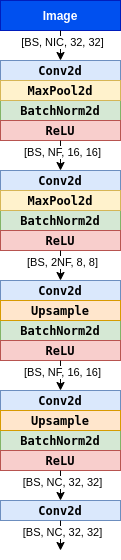

In [66]:
# Download CIFAR dataset
m = load_cifar10()


File path: data/cifar-10-batches-py.tar.gz


In [67]:
# Add the colour.zip folder in the same directory \data\ and extract the files
import zipfile
import os

# Path to the .zip file
zip_file_path = '/content/data/colours.zip'

# Directory where the zip file will be extracted
extract_dir = '/content/data/'

# Extracting the zip file
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f'Extracted files to {extract_dir}')

    # Optionally, list the extracted files
    extracted_files = os.listdir(extract_dir)
    print('Extracted files:', extracted_files)
except FileNotFoundError:
    print(f'Error: The file {zip_file_path} was not found.')
except zipfile.BadZipFile:
    print(f'Error: The file {zip_file_path} is not a valid zip file.')

Extracted files to /content/data/
Extracted files: ['colours.zip', 'cifar-10-batches-py.tar.gz', 'cifar-10-batches-py', 'colours', '__MACOSX', '.ipynb_checkpoints']


In [70]:
class PoolUpsampleNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super().__init__()

        # Useful parameters
        padding = kernel // 2

        #### YOUR CODE STARTS HERE ####
        self.layer1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.MaxPool2d(kernel_size =2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.MaxPool2d(kernel_size =2),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.Upsample(scale_factor =2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(num_filters, num_colours, kernel_size=kernel, padding=padding),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(num_colours),
            nn.ReLU()
        )

        self.output_layer = nn.Conv2d(num_colours, num_colours, kernel_size=kernel, padding=padding)
        #### YOUR CODE ENDS   HERE ####

    def forward(self, x):
        #### YOUR CODE STARTS HERE ####
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.output_layer(x)
        return x
        #### YOUR CODE ENDS   HERE ####

### Question 1

Execute the main training loop for `PoolUpsampleNet`. This process will train the CNN over a few epochs using the cross-entropy loss function. At the end, some images showing the trained output will be produced. Do you think the results look satisfactory? Why or why not?

Loading CIFAR-10 data...
File path: data/cifar-10-batches-py.tar.gz
Transforming CIFAR-10 data...
Beginning training CNN Model ...
Epoch [1/25], Loss: 2.3097, Time (s): 2.20
Epoch [1/25], Val Loss: 1.9978, Val Acc: 32.3%, Time(s): 2.45
Epoch [2/25], Loss: 1.8771, Time (s): 3.14
Epoch [2/25], Val Loss: 1.8146, Val Acc: 36.1%, Time(s): 3.33
Epoch [3/25], Loss: 1.7713, Time (s): 4.12
Epoch [3/25], Val Loss: 1.7466, Val Acc: 37.6%, Time(s): 4.41
Epoch [4/25], Loss: 1.7193, Time (s): 5.24
Epoch [4/25], Val Loss: 1.7224, Val Acc: 37.9%, Time(s): 5.57
Epoch [5/25], Loss: 1.6857, Time (s): 6.48
Epoch [5/25], Val Loss: 1.6743, Val Acc: 39.3%, Time(s): 6.79
Epoch [6/25], Loss: 1.6590, Time (s): 7.59
Epoch [6/25], Val Loss: 1.6494, Val Acc: 40.1%, Time(s): 7.87
Epoch [7/25], Loss: 1.6386, Time (s): 8.71
Epoch [7/25], Val Loss: 1.6440, Val Acc: 40.1%, Time(s): 9.02
Epoch [8/25], Loss: 1.6235, Time (s): 9.87
Epoch [8/25], Val Loss: 1.6392, Val Acc: 40.0%, Time(s): 10.21
Epoch [9/25], Loss: 1.6117, 

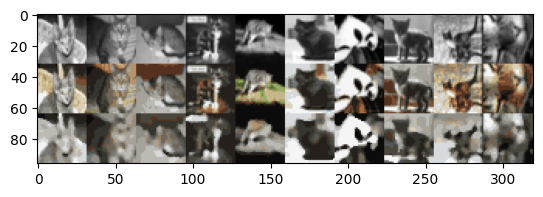

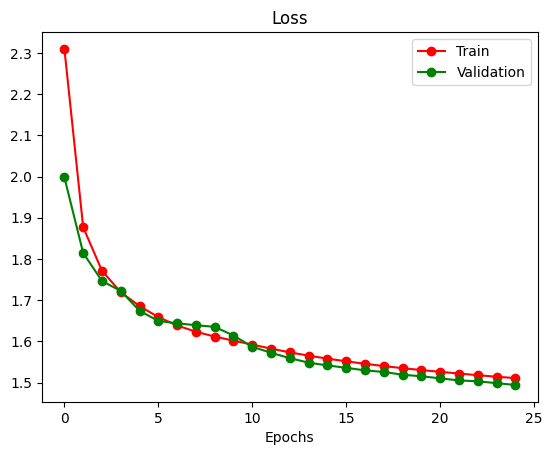

In [71]:
args = AttrDictionary()
args_model_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/col_km24_categ_cat7.npy",
    "model": "PoolUpsampleNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001,
    "batch_sz": 100,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "PoolUpsampleNet_col_cnn",
    "is_plot": False,
    "down_sz_input": False,
}
args.update(args_model_dict)
model = train(args)

### Answer below:

Training and Validation error are close to each other, but they are both a little bit high. This indicates that our model suffers from Underfitting or high bias/low variance.

The first row of images are all black and white, the second row of images are the colored ones and the third row represents the model's predicted images with the colors.

As we can see, the predicted colors are not very accurate, showing us that our model didn't learn enough features.

The reason behind this might be the model being too simple, insufficient training data, or data quality issues.
Additionally, we might not have enough color variations for our pictures making them different than original ones.